In [1]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import random

In [2]:
def enhance_brain_contrast(preprocessed_img_path, brain_mask_path, output_dir, clipLimit=2.0, tileGridSize=(8, 8)):
    """
    Applies CLAHE to the brain region of a preprocessed image using a skull-stripped mask.
    """
    try:
        # Load the preprocessed image (grayscale)
        img = cv2.imread(preprocessed_img_path, 0)
        if img is None:
            print(f"Warning: Could not read preprocessed image {preprocessed_img_path}. Skipping.")
            return

        # Load the brain mask (grayscale)
        mask = cv2.imread(brain_mask_path, 0)
        if mask is None:
            print(f"Warning: Could not read brain mask {brain_mask_path}. Skipping enhancement for {preprocessed_img_path}.")
            return

        # Ensure mask is binary (0 or 255)
        _, mask_binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

        # Isolate the brain region from the preprocessed image using the mask
        # This is the "Before" image for comparison
        brain_only = cv2.bitwise_and(img, img, mask=mask_binary)

        # Apply CLAHE only to the brain region
        clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
        enhanced_brain = clahe.apply(brain_only)

        # Apply the mask again to ensure the background is perfectly black
        enhanced_brain_masked = cv2.bitwise_and(enhanced_brain, enhanced_brain, mask=mask_binary)

        # Save the result
        base_filename = os.path.basename(preprocessed_img_path)
        output_filename = base_filename.replace('.png', '_clahe.png')
        output_path = os.path.join(output_dir, output_filename)
        cv2.imwrite(output_path, enhanced_brain_masked)

    except Exception as e:
        print(f"Error processing {preprocessed_img_path} with mask {brain_mask_path}: {e}")

In [3]:
PREPROCESSED_BASE_DIR = '/content/drive/MyDrive/processed_images'
MASK_BASE_DIR = '/content/drive/MyDrive/skull_stripped_masks'
OUTPUT_BASE_DIR = '/content/drive/MyDrive/clahe_enhanced_brains'
ORIGINAL_DATA_BASE_DIR = '/content/drive/MyDrive/original_data'

TUMOR_TYPES = ['Meningioma', 'Glioma', 'Pituitary tumor']

In [4]:
print("--- Starting Module 3: CLAHE Enhancement ---")

for tumor_type in TUMOR_TYPES:
    preprocessed_dir = os.path.join(PREPROCESSED_BASE_DIR, tumor_type)
    mask_dir = os.path.join(MASK_BASE_DIR, tumor_type)
    output_dir = os.path.join(OUTPUT_BASE_DIR, tumor_type)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created directory: {output_dir}")

    # Find all preprocessed image files
    search_pattern = os.path.join(preprocessed_dir, '*.png')
    preprocessed_paths = [p for p in glob.glob(search_pattern) if '_mask' not in p]

    print(f"\nProcessing {tumor_type} images...")
    processed_count = 0
    skipped_count = 0
    for img_path in preprocessed_paths:
        base_filename = os.path.basename(img_path)

        # Construct the expected mask filename
        mask_filename = base_filename.replace('.png', '_brain_mask.png')
        mask_path = os.path.join(mask_dir, mask_filename)

        if os.path.exists(mask_path):
            enhance_brain_contrast(img_path, mask_path, output_dir)
            processed_count += 1
        else:
            # This is expected based on your previous error, it's not a bug
            # print(f"  Mask not found for {base_filename} at {mask_path}, skipping.")
            skipped_count += 1

    print(f"Finished {tumor_type}: Processed {processed_count}, Skipped {skipped_count} (due to missing masks)")

print("\n✅ Module 3 (CLAHE Enhancement) complete. Outputs are in clahe_enhanced_brains.")

--- Starting Module 3: CLAHE Enhancement ---

Processing Meningioma images...
Finished Meningioma: Processed 708, Skipped 0 (due to missing masks)

Processing Glioma images...
Finished Glioma: Processed 1426, Skipped 0 (due to missing masks)

Processing Pituitary tumor images...
Finished Pituitary tumor: Processed 930, Skipped 0 (due to missing masks)

✅ Module 3 (CLAHE Enhancement) complete. Outputs are in clahe_enhanced_brains.



--- Running Module 3 Comparison (CLAHE vs. Global HE) ---


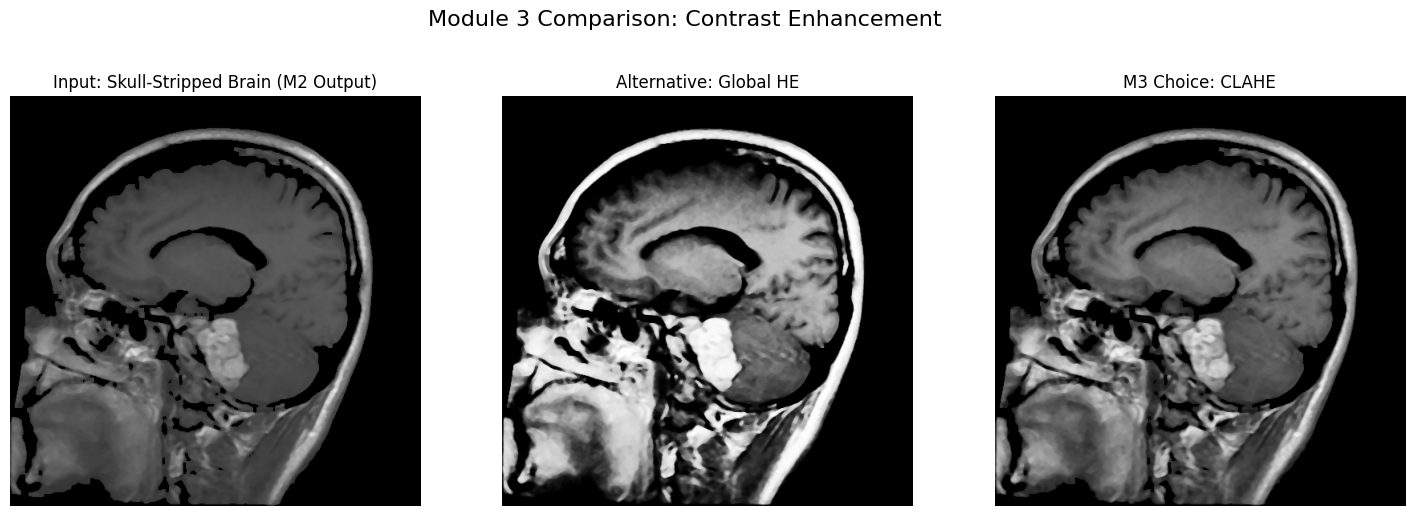


Comparison script finished.


In [5]:

TUMOR_TYPE = 'Glioma'
EXAMPLE_FILE = '2569.png'
# --- Build paths for the example file ---
original_img_path = os.path.join(ORIGINAL_DATA_BASE_DIR, TUMOR_TYPE, EXAMPLE_FILE)
preprocessed_img_path = os.path.join(PREPROCESSED_BASE_DIR, TUMOR_TYPE, EXAMPLE_FILE)
skull_mask_path = os.path.join(MASK_BASE_DIR, TUMOR_TYPE, EXAMPLE_FILE.replace('.png', '_brain_mask.png'))

# Load all images needed
original_img = cv2.imread(original_img_path, 0)
preprocessed_img = cv2.imread(preprocessed_img_path, 0)
skull_mask = cv2.imread(skull_mask_path, 0)

# --- M3 Comparison: CLAHE vs. Global HE ---
print("\n--- Running Module 3 Comparison (CLAHE vs. Global HE) ---")
if preprocessed_img is not None and skull_mask is not None:

    # Isolate brain region first
    brain_only = cv2.bitwise_and(preprocessed_img, preprocessed_img, mask=skull_mask)

    # 1. Alternative: Global Histogram Equalization
    global_he = cv2.equalizeHist(brain_only)
    # Mask again as equalizeHist might brighten black pixels
    global_he_masked = cv2.bitwise_and(global_he, global_he, mask=skull_mask)

    # 2. Your M3 Choice: CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_enhanced = clahe.apply(brain_only)
    # Mask again to ensure clean background
    clahe_enhanced_masked = cv2.bitwise_and(clahe_enhanced, clahe_enhanced, mask=skull_mask)

    # Plotting
    fig2, axes2 = plt.subplots(1, 3, figsize=(18, 6))
    fig2.suptitle('Module 3 Comparison: Contrast Enhancement', fontsize=16)

    axes2[0].imshow(brain_only, cmap='gray')
    axes2[0].set_title('Input: Skull-Stripped Brain (M2 Output)')
    axes2[0].axis('off')

    axes2[1].imshow(global_he_masked, cmap='gray')
    axes2[1].set_title('Alternative: Global HE')
    axes2[1].axis('off')

    axes2[2].imshow(clahe_enhanced_masked, cmap='gray')
    axes2[2].set_title('M3 Choice: CLAHE')
    axes2[2].axis('off')

    plt.show()
else:
    print(f"M3 Comparison Error: Could not load images for M3 comparison. Check paths:")
    if preprocessed_img is None: print(f"  Missing: {preprocessed_img_path}")
    if skull_mask is None: print(f"  Missing: {skull_mask_path}")

print("\nComparison script finished.")

In [6]:
# Renamed for clarity
clahe_base_dir = '/content/drive/MyDrive/clahe_enhanced_brains'

def visualize_stages(original_preprocessed_path, skull_mask_path, clahe_enhanced_path):
    """Loads and displays the three image stages side-by-side."""

    # Load images in grayscale
    img_preprocessed = cv2.imread(original_preprocessed_path, 0)
    img_skull_mask = cv2.imread(skull_mask_path, 0)
    img_clahe = cv2.imread(clahe_enhanced_path, 0)

    # Check if all images loaded correctly
    if img_preprocessed is None or img_skull_mask is None or img_clahe is None:
        print("Error: Could not load one or more images. Check paths:")
        if img_preprocessed is None: print(f"  Failed: {original_preprocessed_path}")
        if img_skull_mask is None: print(f"  Failed: {skull_mask_path}")
        if img_clahe is None: print(f"  Failed: {clahe_enhanced_path}")
        return

    # Create the plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # 1 row, 3 columns

    axes[0].imshow(img_preprocessed, cmap='gray')
    axes[0].set_title('1. Preprocessed (Median Filter)')
    axes[0].axis('off')

    axes[1].imshow(img_skull_mask, cmap='gray')
    axes[1].set_title('2. Skull-Stripped Mask')
    axes[1].axis('off')

    axes[2].imshow(img_clahe, cmap='gray')
    axes[2].set_title('3. CLAHE Enhanced Brain')
    axes[2].axis('off')

    # Add an overall title with the base filename
    base_filename = os.path.basename(original_preprocessed_path)
    plt.suptitle(f'Processing Stages for: {base_filename}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
    plt.show()

Generating visualizations...

Visualizing example for Meningioma...
  Displaying: 119.png


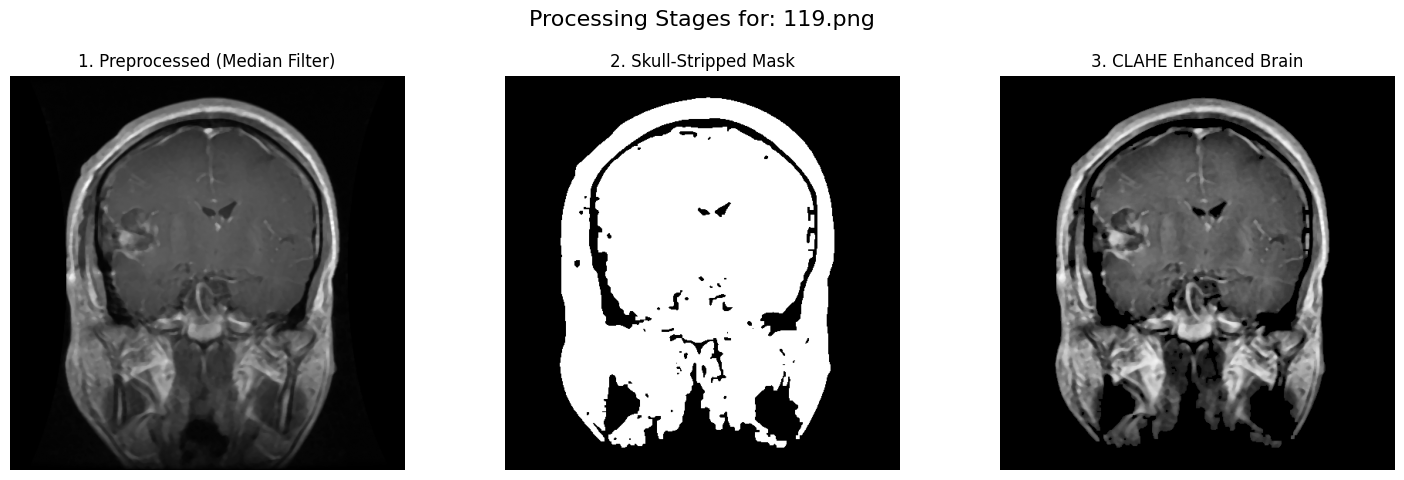


Visualizing example for Glioma...
  Displaying: 2301.png


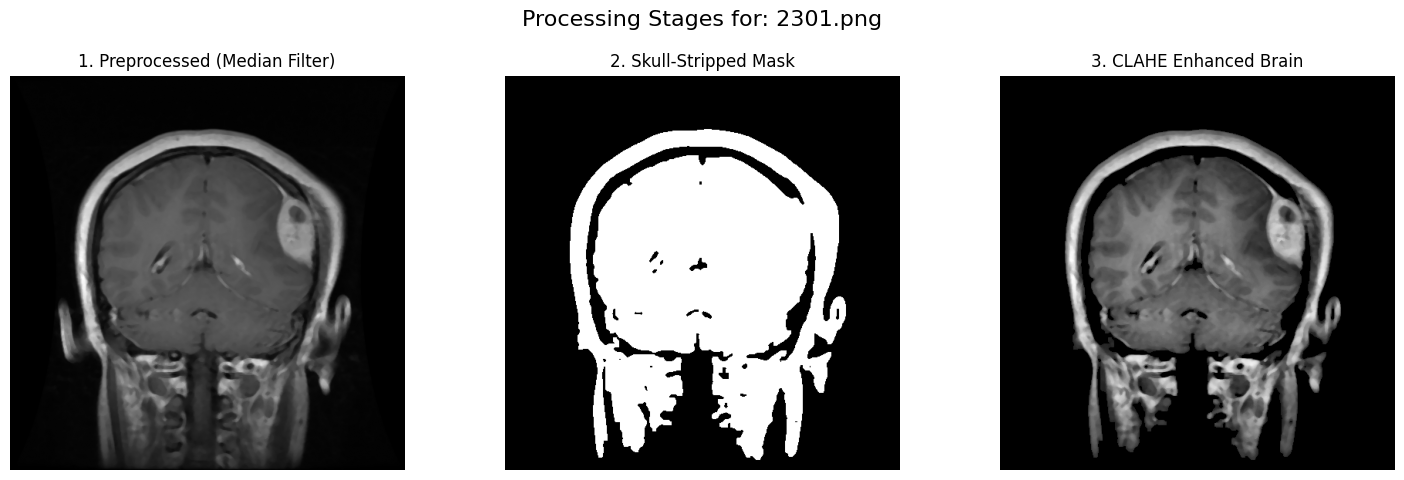


Visualizing example for Pituitary tumor...
  Displaying: 1533.png


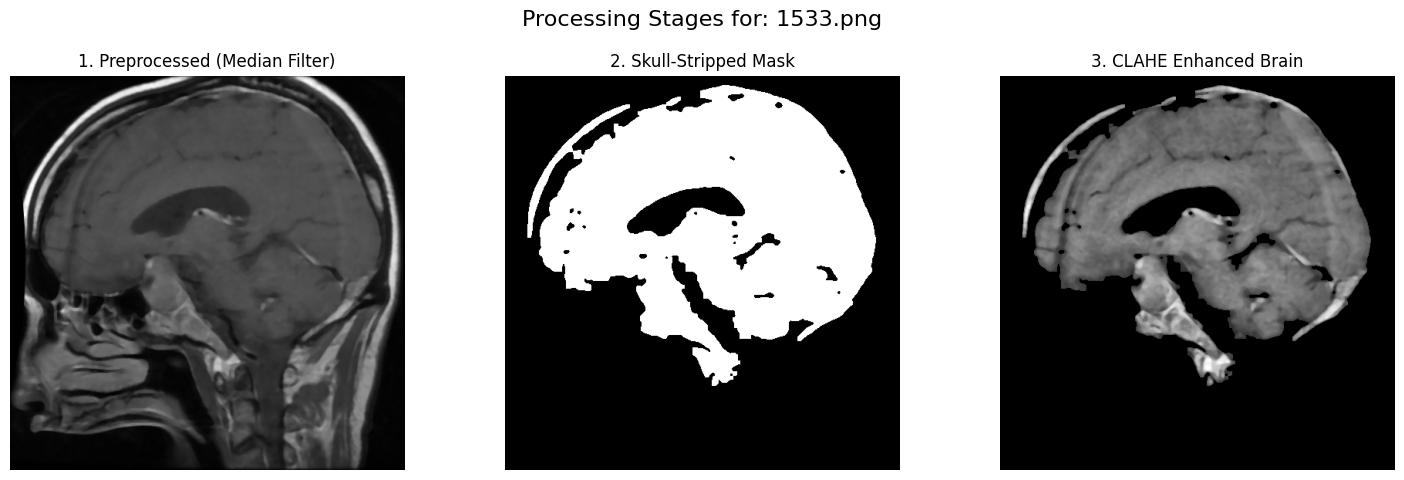


--- Visualization finished ---


In [7]:
print("Generating visualizations...")
for tumor_type in TUMOR_TYPES:
    print(f"\nVisualizing example for {tumor_type}...")

    # --- Explicitly define directories for the CURRENT tumor type ---
    current_preprocessed_dir = os.path.join(PREPROCESSED_BASE_DIR, tumor_type)
    current_mask_dir = os.path.join(MASK_BASE_DIR, tumor_type)
    current_clahe_dir = os.path.join(clahe_base_dir, tumor_type)

    # Find all preprocessed images in the current preprocessed directory
    search_pattern = os.path.join(current_preprocessed_dir, '*.png')
    preprocessed_files = [p for p in glob.glob(search_pattern) if '_mask' not in p and '_clahe' not in p and '_brain_mask' not in p]

    if not preprocessed_files:
        print(f"  No preprocessed images found in {current_preprocessed_dir}. Skipping.")
        continue

    # Pick a random image file from the current directory
    random_img_path = random.choice(preprocessed_files)
    base_filename = os.path.basename(random_img_path)

    # --- Construct full paths using the CORRECT directories for the current tumor type ---
    skull_mask_filename = base_filename.replace('.png', '_brain_mask.png')
    skull_mask_path = os.path.join(current_mask_dir, skull_mask_filename) # Use current_mask_dir

    clahe_filename = base_filename.replace('.png', '_clahe.png')
    clahe_enhanced_path = os.path.join(current_clahe_dir, clahe_filename) # Use current_clahe_dir

    # Check if all corresponding files exist before trying to visualize
    if os.path.exists(random_img_path) and os.path.exists(skull_mask_path) and os.path.exists(clahe_enhanced_path):
        print(f"  Displaying: {base_filename}")
        visualize_stages(random_img_path, skull_mask_path, clahe_enhanced_path)
    else:
        print(f"  Skipping visualization for {base_filename}: Corresponding file(s) not found.")
        # Print expected paths for debugging
        if not os.path.exists(random_img_path): print(f"    Missing Preprocessed Check: {random_img_path}") # Should exist
        if not os.path.exists(skull_mask_path): print(f"    Expected Skull Mask at: {skull_mask_path}")
        if not os.path.exists(clahe_enhanced_path): print(f"    Expected CLAHE Image at: {clahe_enhanced_path}")

print("\n--- Visualization finished ---")

In [8]:
!zip -r /content/clahe_enhanced_brains.zip /content/drive/MyDrive/clahe_enhanced_brains

  adding: content/drive/MyDrive/clahe_enhanced_brains/ (stored 0%)
  adding: content/drive/MyDrive/clahe_enhanced_brains/Meningioma/ (stored 0%)
  adding: content/drive/MyDrive/clahe_enhanced_brains/Meningioma/685_clahe.png (deflated 1%)
  adding: content/drive/MyDrive/clahe_enhanced_brains/Meningioma/677_clahe.png (deflated 0%)
  adding: content/drive/MyDrive/clahe_enhanced_brains/Meningioma/584_clahe.png (deflated 0%)
  adding: content/drive/MyDrive/clahe_enhanced_brains/Meningioma/684_clahe.png (deflated 1%)
  adding: content/drive/MyDrive/clahe_enhanced_brains/Meningioma/90_clahe.png (deflated 1%)
  adding: content/drive/MyDrive/clahe_enhanced_brains/Meningioma/556_clahe.png (deflated 0%)
  adding: content/drive/MyDrive/clahe_enhanced_brains/Meningioma/608_clahe.png (deflated 1%)
  adding: content/drive/MyDrive/clahe_enhanced_brains/Meningioma/658_clahe.png (deflated 1%)
  adding: content/drive/MyDrive/clahe_enhanced_brains/Meningioma/576_clahe.png (deflated 0%)
  adding: content/d